In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Algoritmo híbrido para la selección de atributos

### Lectura de datos

In [4]:
from project.utils import read_datasets
from project.utils.io import describe

corpus = "test"

datasets = read_datasets(corpus)
dataset = datasets[0]
X = dataset.X
y = dataset.y

describe(dataset)

Dataset: 		 dataset_glioma_rickman
Nro de muestras: 	 40
Nro de atributos: 	 2000
Nro de clases: 		 2
Muestras por clase: 
			 0 -> 19
			 1 -> 21


## Filtro de atributos por métodos de ranking

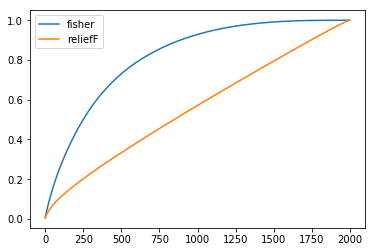

In [5]:
from project.rankers import FeatureFilter

ranker_methods = ["reliefF", "fisher"]
ff = FeatureFilter(ranker_methods, score_threshold=0.2)

ff.evaluate_rankers(dataset)
ff.normalize()
ff.plot()

In [6]:
features = ff.filter_features()
features

{'fisher': array([ 226, 1580,  485, 1394, 1223,  298,  703,  257, 1106,   83,   81,
          27, 1085,  718,    3, 1058,   48,   71, 1669, 1455,  220, 1977,
        1541,   49,  137,  672,  686,  797,  341,  609, 1469,  209,  676,
        1572,  749, 1753, 1121, 1055, 1070,  831, 1987, 1523,  482, 1666,
         238,  132,  613,  775,  101, 1128,   97,  901, 1313,  504,  818,
         995,  591,  500,  449,  996, 1637, 1317,  698,  936, 1818, 1160,
         148,  103,  521]),
 'reliefF': array([   3,    0,   27,   49,    2,   83,   37,    7,   13,   17,  101,
          20,    5,  148,   21,   48,   81,   39,   71,   12,  226,   52,
          68,   11,   97,  197,   18,  298,   32,  257,   16,    6,  209,
         134,  238,   72,  190,  103,  127,   29,  114,  220,  131,   84,
         299,   53,  193,   85,  132,    8,  137,   88,   10,   61,  149,
         111,  485,  248,  251,   76,  482,   38,  263,  115,  208,  210,
         306,   50,  222,   30,  135,   79,   58,  504,  195,  

## Algoritmo genético

In [11]:
import project.genetic_algorithm as GA


Se evaluará el número de generaciones a utilizar.

In [12]:
from functools import reduce
from sklearn.base import TransformerMixin
from sklearn.model_selection import cross_val_predict
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from project.rankers import FeatureFilter
import project.genetic_algorithm as GA
from sklearn.preprocessing import StandardScaler

class GAFeatureSelection(TransformerMixin):
    def __init__(self, ranker_methods, score_threshold, estimator, metric, cv, acc_weight):
        self.ranker_methods = ranker_methods
        self.score_threshold = score_threshold
        self.estimator = estimator
        self.metric = metric
        self.cv = cv
        self.acc_weight = acc_weight
        
    def fit(self, X, y=None, **fit_params):        
        ff = FeatureFilter(self.ranker_methods, score_threshold=self.score_threshold)
        ff._evaluate_rankers(X, y)
        ff.normalize()
        
        features = ff.filter_features()
        ranker_features = reduce(np.union1d, features.values())
        
        fitness_function = lambda dna: GA.cho_fitness_function(dna,
            X, y, ranker_features,
            self.estimator, self.metric, self.cv,
            acc_weight=self.acc_weight)
        
        GA.Individual.Configure(dna_size=len(ranker_features),
                                fitness_function=fitness_function)
        ga = GA.GeneticAlgorithm(generations=20)
        fittest,_ = ga.run(n_iter=20, plot=False)
        
        self.selected_features = ranker_features[fittest.dna]
        return self
    
    def transform(self, X, **transform_params):        
        return X[:, self.selected_features]

In [13]:
from sklearn.base import TransformerMixin
from project.rankers import select_features
from project.utils.metrics import evaluate_metric

class RankerFeatureSelection(TransformerMixin):
    def __init__(self, fs_key, n_features, estimator, cv):
        self.fs_key = fs_key
        self.n_features = n_features
        self.estimator = estimator
        self.cv = cv
        
    def fit(self, X, y=None, **fit_params):
        y_preds = {}
        for i in range(1, self.n_features+1):
            y_preds[i] = -1 * np.ones(y.shape)
            
        for train, test in self.cv.split(X, y):
            X_train, X_test = X[train], X[test]
            y_train, y_test = y[train], y[test]
            
            selected_features = select_features(
                self.fs_key, X_train, y_train,
                self.n_features)
            
            for nf, features in selected_features.items():
                X_train_selected = X_train[:, features]
                X_test_selected = X_test[:, features]
                
                self.estimator.fit(X_train_selected, y_train)
                y_pred = self.estimator.predict(X_test_selected)                
                y_preds[nf][test] = y_pred
        
        
        scores = {nf: evaluate_metric("gmean", y, y_pred)
                  for nf, y_pred in y_preds.items()}
        
        best_nf = max(scores, key=lambda key:scores[key])
        selected_features = select_features(
            self.fs_key, X, y, self.n_features)
        
        self.selected_features = selected_features[best_nf]
        return self
    
    def transform(self, X, **transform_params):                
        return X[:, self.selected_features] 


En primer lugar, se mostrará la media y varianza de los mejores fitness alcanzados en 20 iteraciones del algoritmo.


In [14]:
def ga_test(ranker_methods, score_threshold, X, y, estimator, metric, cv, acc_weight, generations):
    ff = FeatureFilter(ranker_methods, score_threshold=score_threshold)
    ff._evaluate_rankers(X, y)
    ff.normalize()

    features = ff.filter_features()
    ranker_features = reduce(np.union1d, features.values())


    fitness_function = lambda dna: GA.cho_fitness_function(dna,
        X, y, ranker_features,
        estimator, metric, cv,
        acc_weight= acc_weight)

    GA.Individual.Configure(dna_size=len(ranker_features),
                            fitness_function=fitness_function)
    ga = GA.GeneticAlgorithm(generations=generations)
    fittest, selected = ga.run(n_iter=20, plot=False)
    return selected

In [15]:
X = dataset.X
y = dataset.y

ranker_methods = ["reliefF"]
score_threshold = 0.2
estimator = LinearSVC()
metric = "gmean"
cv = StratifiedKFold(3)
acc_weight = 0.9
generations = 20

selected = ga_test(ranker_methods, score_threshold, X, y, estimator, metric, cv, acc_weight, generations)

In [ ]:
gens = []
selected_by_gen = []
mean_by_gen = []
var_by_gen = []
for g in range(5, 41, 5):    
    gens.append(g)    
    selected = foo(ranker_methods, score_threshold, X, y, estimator, metric, cv, acc_weight, g)
    selected_by_gen.append(selected)
    
    sel_fitness = [i.fitness for i in selected]
    
    mean_by_gen.append(np.mean(sel_fitness))
    var_by_gen.append(np.var(sel_fitness))
    
    print(g, np.mean(sel_fitness), np.var(sel_fitness))

In [ ]:
plt.plot(gens, mean_by_gen)

In [ ]:
plt.plot(gens, var_by_gen)

### Evaluación de método de filtro

In [ ]:
pipe_reliefF = Pipeline([
    ('norm', StandardScaler()),
    ('fs', RankerFeatureSelection("reliefF", 100, LinearSVC(), StratifiedKFold(3))),
    ('clf', LinearSVC()),
])

pipe_ga_reliefF = Pipeline([
    ('norm', StandardScaler()),
    ('fs', GAFeatureSelection(["reliefF"], 0.2, LinearSVC(), "gmean", StratifiedKFold(3), 0.9)),
    ('clf', LinearSVC()),
])

df = []
for i, dataset in enumerate(datasets):
    print(i+1, dataset.name)
    
    X = dataset.X
    y = dataset.y
    
    y_pred_reliefF = cross_val_predict(pipe_reliefF, X, y, cv=StratifiedKFold(3), n_jobs=-1)
    y_pred_ga_reliefF = cross_val_predict(pipe_ga_reliefF, X, y, cv=StratifiedKFold(3), n_jobs=-1)
    
    df.append({"dataset": dataset.name,
               "reliefF": evaluate_metric("gmean", y, y_pred_reliefF),
               "ga_reliefF": evaluate_metric("gmean", y, y_pred_ga_reliefF),
              })

1 dataset_glioma_rickman
2 dataset_ovarian_li_and_campbell
3 dataset_breast_gruvberger
4 dataset_mixed_chowdary
5 dataset_prostate_tomlins
6 dataset_lymphoma_shipp


In [10]:
df = pd.DataFrame(df)

df = df.set_index('dataset')
df

,ga_reliefF,reliefF
dataset,,
dataset_glioma_rickman,0.872872,0.786796
dataset_ovarian_li_and_campbell,0.870823,0.893650
dataset_breast_gruvberger,0.755929,0.914174
dataset_mixed_chowdary,0.991903,0.980023
dataset_prostate_tomlins,0.877811,0.728756
dataset_lymphoma_shipp,0.878251,0.783218
dataset_liver_chen,0.975305,0.968182
dataset_myeloma_tian,0.503032,0.558064
dataset_leukemia_andersson,0.953649,0.910825


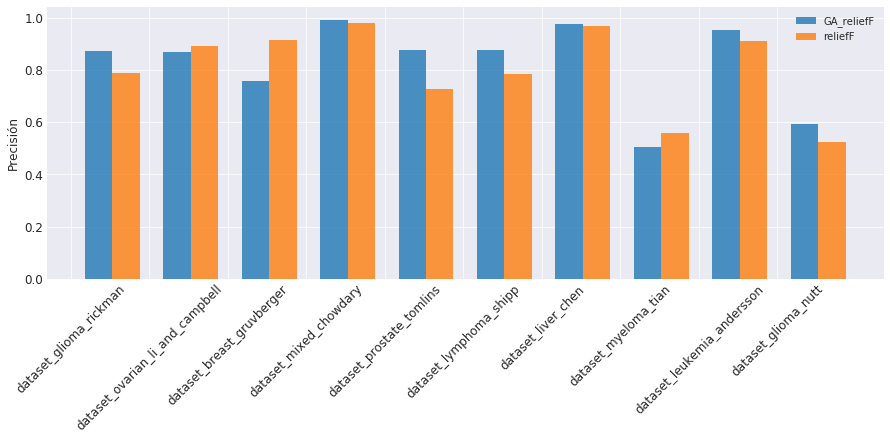

In [55]:
import seaborn as sns
sns.set_style("darkgrid")

n_groups = 10
index = np.arange(n_groups)
fig, ax = plt.subplots(figsize=(15, 5))


index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
rects1 = plt.bar(index, df['ga_reliefF'], bar_width,
                 alpha=opacity,                 
                 label='GA_reliefF')
 
rects2 = plt.bar(index + bar_width, df['reliefF'], bar_width,
                 alpha=opacity,                 
                 label='reliefF')

plt.rc('font', size=10) 
plt.ylabel("Precisión")
plt.xticks(index-bar_width, df.index, rotation=45)
plt.legend()
plt.show()

In [13]:
pipe_reliefF = Pipeline([
    ('norm', StandardScaler()),
    ('fs', RankerFeatureSelection("reliefF", 100, LinearSVC(), StratifiedKFold(3))),
    ('clf', LinearSVC()),
])

pipe_fisher = Pipeline([
    ('norm', StandardScaler()),
    ('fs', RankerFeatureSelection("fisher", 100, LinearSVC(), StratifiedKFold(3))),
    ('clf', LinearSVC()),
])

pipe_ga_reliefF_fisher = Pipeline([
    ('norm', StandardScaler()),
    ('fs', GAFeatureSelection(["fisher", "reliefF"], 0.2, LinearSVC(), "gmean", StratifiedKFold(3), 0.9)),
    ('clf', LinearSVC()),
])

df3 = []
for i, dataset in enumerate(datasets):
    print(i+1, dataset.name)
    
    X = dataset.X
    y = dataset.y
    
    y_pred_reliefF = cross_val_predict(pipe_reliefF, X, y, cv=StratifiedKFold(3), n_jobs=-1)
    y_pred_fisher = cross_val_predict(pipe_fisher, X, y, cv=StratifiedKFold(3), n_jobs=-1)
    
    y_pred_ga_reliefF_fisher = cross_val_predict(pipe_ga_reliefF_fisher, X, y, cv=StratifiedKFold(3), n_jobs=-1)
    
    df3.append({"dataset": dataset.name,
               "reliefF": evaluate_metric("gmean", y, y_pred_reliefF),
               "fisher": evaluate_metric("gmean", y, y_pred_fisher),
               "ga_reliefF_fisher": evaluate_metric("gmean", y, y_pred_ga_reliefF_fisher),
              })

df3 = pd.DataFrame(df3)
df3 = df3.set_index('dataset')

1 dataset_glioma_rickman
2 dataset_ovarian_li_and_campbell
3 dataset_breast_gruvberger
4 dataset_mixed_chowdary
5 dataset_prostate_tomlins
6 dataset_lymphoma_shipp
7 dataset_liver_chen
8 dataset_myeloma_tian
9 dataset_leukemia_andersson
10 dataset_glioma_nutt


In [14]:
df3

,fisher,ga_reliefF_fisher,reliefF
dataset,,,
dataset_glioma_rickman,0.807235,0.794719,0.786796
dataset_ovarian_li_and_campbell,0.874007,0.912871,0.893650
dataset_breast_gruvberger,0.914174,0.810643,0.914174
dataset_mixed_chowdary,0.955821,0.980023,0.980023
dataset_prostate_tomlins,0.783043,0.815070,0.728756
dataset_lymphoma_shipp,0.666818,0.904215,0.783218
dataset_liver_chen,0.981537,0.974882,0.968182
dataset_myeloma_tian,0.602778,0.545943,0.558064
dataset_leukemia_andersson,0.943382,0.943382,0.910825


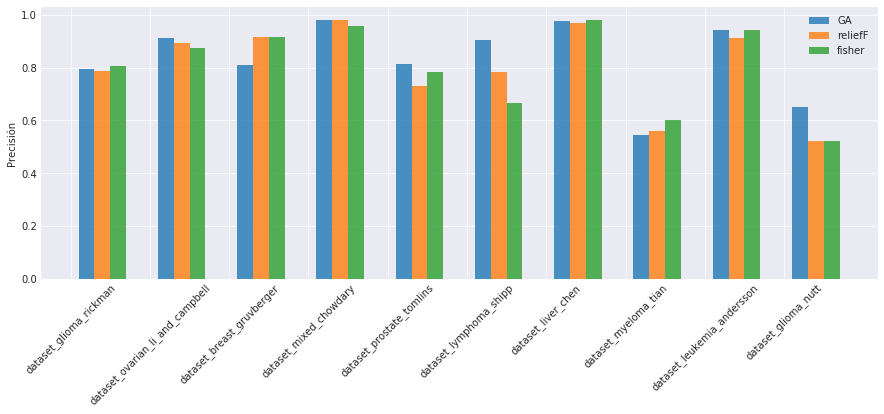

In [25]:


import seaborn as sns
sns.set_style("darkgrid")

n_groups = 10
index = np.arange(n_groups)
fig, ax = plt.subplots(figsize=(15, 5))


index = np.arange(n_groups)
bar_width = 0.2

opacity = 0.8

rects2 = plt.bar(index, df3['ga_reliefF_fisher'], bar_width,
                 alpha=opacity,                 
                 label='GA')

rects1 = plt.bar(index + bar_width, df3['reliefF'], bar_width,
                 alpha=opacity,                 
                 label='reliefF')
 
rects2 = plt.bar(index + 2*bar_width, df3['fisher'], bar_width,
                 alpha=opacity,                 
                 label='fisher')



plt.rc('font', size=10) 
plt.ylabel("Precisión")
plt.xticks(index-bar_width, df2.index, rotation=45)
plt.legend()
plt.show()

In [26]:
for dataset in datasets:
    print(dataset.name)

dataset_glioma_rickman
dataset_ovarian_li_and_campbell
dataset_breast_gruvberger
dataset_mixed_chowdary
dataset_prostate_tomlins
dataset_lymphoma_shipp
dataset_liver_chen
dataset_myeloma_tian
dataset_leukemia_andersson
dataset_glioma_nutt
